Compare two held-out evaluations sensor-wise.

In [1]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import pandas as pd
import seaborn as sns

In [2]:
eval1 = "../workflow/heilbron2022/evaluations/shift075_vs_baseline/EleutherAI/gpt-neo-2.7B/n10000/test_scores.csv"
eval2 = "../workflow/heilbron2022/evaluations/variable_vs_baseline/EleutherAI/gpt-neo-2.7B/n10000/test_scores.csv"
# eval1 = "test_scores1.csv"
# eval2 = "test_scores2.csv"

montage = "biosemi128"

In [3]:
converters = {"model_run": ast.literal_eval}
index_cols = ["model_run", "subject", "run", "sensor"]
eval1_df = pd.read_csv(eval1, converters=converters, index_col=index_cols)
eval2_df = pd.read_csv(eval2, converters=converters, index_col=index_cols)

In [4]:
sensors = sorted(set(eval1_df.index.get_level_values("sensor")))
assert sensors == sorted(set(eval2_df.index.get_level_values("sensor")))

In [5]:
eval1_models = eval1_df.index.get_level_values("model_run").unique()
eval2_models = eval2_df.index.get_level_values("model_run").unique()
base_model = set(eval1_models) & set(eval2_models)
assert len(base_model) == 1
base_model = next(iter(base_model))
eval1_full = next(iter(set(eval1_models) - {base_model}))
eval2_full = next(iter(set(eval2_models) - {base_model}))

In [6]:
eval1_improvement = eval1_df.loc[eval1_full] - eval1_df.loc[base_model]
eval2_improvement = eval2_df.loc[eval2_full] - eval2_df.loc[base_model]

In [7]:
eval1_df

score
model_run                    subject run                    sensor          
(_wide, trf)                 1       run1/slice:17214:22949 A19    -0.000624
                                                            A7     -0.006729
                                                            B22     0.077013
                                                            B4      0.028612
                                                            C10     0.093331
...                                                                      ...
(_wide, trf-berp-fixed-t075) 9       run9/slice:16884:22511 B4      0.052107
                                                            C10     0.107589
                                                            C22     0.111273
                                                            C32     0.079160
                                                            D19     0.071036

[5776 rows x 1 columns]

-------

In [8]:
info = mne.create_info(sensors, 128, "eeg")
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: A19, A7, B22, B4, C10, C22, C32, D19
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 128.0 Hz
>

In [9]:
eval1_improvement_sensors = eval1_improvement.groupby("sensor").score.mean()
eval1_improvement_sensors.sort_values()

sensor
C32    0.000161
A7     0.000201
B22    0.000462
A19    0.000486
C10    0.000517
D19    0.000587
C22    0.000635
B4     0.000645
Name: score, dtype: float64

In [10]:
eval2_improvement_sensors = eval2_improvement.groupby("sensor").score.mean()
eval2_improvement_sensors.sort_values()

sensor
C10    0.001378
C32    0.001557
B22    0.001707
C22    0.001845
D19    0.002135
A7     0.002140
B4     0.002252
A19    0.002257
Name: score, dtype: float64

In [11]:
improvements = pd.DataFrame([eval1_improvement_sensors, eval2_improvement_sensors], index=["eval1", "eval2"]).T.sort_index()
improvements

,eval1,eval2
sensor,,
A19,0.000486,0.002257
A7,0.000201,0.002140
B22,0.000462,0.001707
B4,0.000645,0.002252
C10,0.000517,0.001378
C22,0.000635,0.001845
C32,0.000161,0.001557
D19,0.000587,0.002135


In [12]:
vlim = (improvements.values.min(), improvements.values.max())
from matplotlib.colors import CenteredNorm

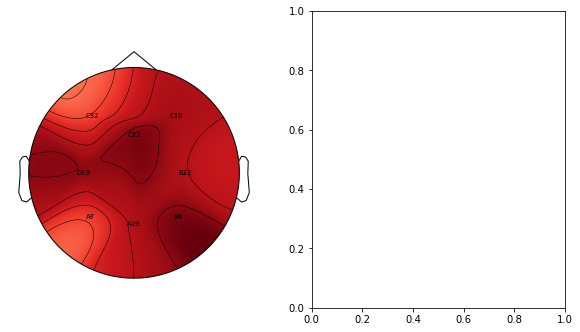

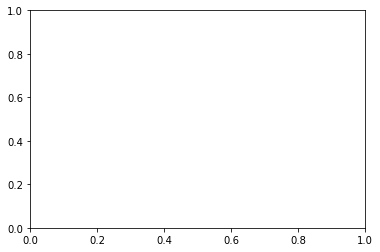

In [13]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
im1, _ = mne.viz.plot_topomap(improvements.eval1,
                              info, cnorm=CenteredNorm(), axes=axs[0], names=improvements.index)
# im2, _ = mne.viz.plot_topomap(improvements.eval2,
#                               info, vlim=vlim, axes=axs[1])
plt.colorbar(im1)

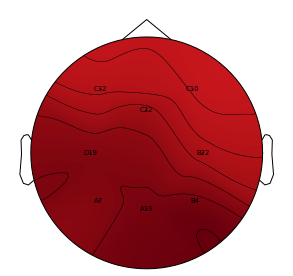

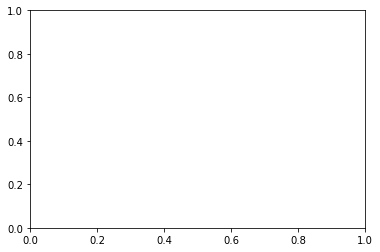

In [14]:
im2, _ = mne.viz.plot_topomap(improvements.eval2,
                              info, cnorm=CenteredNorm(), size=5, names=improvements.index)
plt.colorbar(im2)

-------

In [15]:
(improvements.eval2 - improvements.eval1)

sensor
A19    0.001771
A7     0.001939
B22    0.001245
B4     0.001607
C10    0.000861
C22    0.001209
C32    0.001395
D19    0.001548
dtype: float64

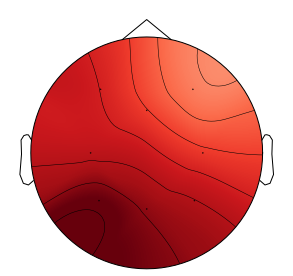

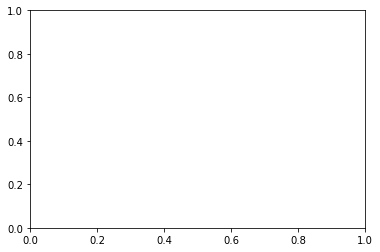

In [16]:
im, _ = mne.viz.plot_topomap((improvements.eval2 - improvements.eval1).sort_index(),
                              info, size=5)
plt.colorbar(im)